In [12]:
from sklearn.manifold import TSNE
import torch
import os
import pickle

import numpy as np
import torch.nn as nn
import torchvision.models as models
from tqdm.auto import tqdm

from policy import config
from policy.dataset.dataset_loaders import dataset_loader
from policy.checkpoints import CheckpointIO

model_dir = "/home/mrl/Documents/Projects/tskill/out/Plan/003"
cfg_path = os.path.join(model_dir, "config.yaml")
cfg = config.load_config(cfg_path, None)
method = cfg["method"]
if method == "plan":
    cfg["vae_cfg"] = config.load_config(os.path.join(cfg["model"]["vae_path"],"config.yaml"))

# Dataset
cfg["data"]["pad"] = True
cfg["data"]["augment"] = False
cfg["data"]["full_seq"] = False
cfg["data"]["max_count"] = 10
# cfg["data"]["val_split"] = 0.9

# Load only the full episode version of the dataset
train_dataset, val_dataset = dataset_loader(cfg, return_datasets=True, 
                                            save_override=True,
                                            fullseq_override=True,
                                            preshuffle=False,
                                            pad2msl=True)
print(len(train_dataset), len(val_dataset))
# Model
model = config.get_model(cfg, device="cpu")
checkpoint_io = CheckpointIO(model_dir, model=model)
load_dict = checkpoint_io.load("model.pt")
stt_encoder = model.stt_encoder
model.eval()

Found existing data info file
Loading indices from file: out/Plan/003/data_info.pickle
Overriding full seq config!
Loading action and state scaling from file
Adding batch dimension to returned data!
Padding only to a multiple of max_skill_len. Ensure batch size is 1!
Padding only to a multiple of max_skill_len. Ensure batch size is 1!
45 5
freezing state encoder network!
/home/mrl/Documents/Projects/tskill/out/VAE/007/model_best.pt
=> Loading checkpoint from local file...
load state dict: <All keys matched successfully>
Freezing state encoder network!
Freezing CVAE network!
/home/mrl/Documents/Projects/tskill/out/Plan/003/model.pt
=> Loading checkpoint from local file...


/home/mrl/miniconda3/envs/tskill/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mrl/miniconda3/envs/tskill/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


load state dict: <All keys matched successfully>


TSkillPlan(
  (transformer): TransformerDecoder(
    (layers): ModuleList(
      (0-9): 10 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (dropout3): Dropout(p=0.1, inplace=False)
      )
    )
   

In [13]:
mus = torch.zeros((0,model.z_dim))
lvs = torch.zeros((0,model.z_dim))
pms = torch.zeros((0,model.z_dim))
lengths = []
# for i in tqdm(range(len(train_dataset))):
for i in tqdm(range(5)):
    data = val_dataset[i]
    
    with torch.no_grad():
        out = model(data, use_precalc=True)
    
    pms = torch.vstack((pms, out["z_hat"].squeeze()))
    mus = torch.vstack((mus, out["vae_out"]["mu"].squeeze()))
    lvs = torch.vstack((lvs, out["vae_out"]["logvar"].squeeze()))
    lengths.append(out["vae_out"]["mu"].shape[1])
print(mus.shape) # torch.Size([926, 128])
print(lvs.shape) # torch.Size([926, 128])
print(lengths) # [19, 19, 20, 19, 18, 20, 19, 19, 20,...]

100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

torch.Size([99, 8])
torch.Size([99, 8])
[20, 20, 19, 20, 20]


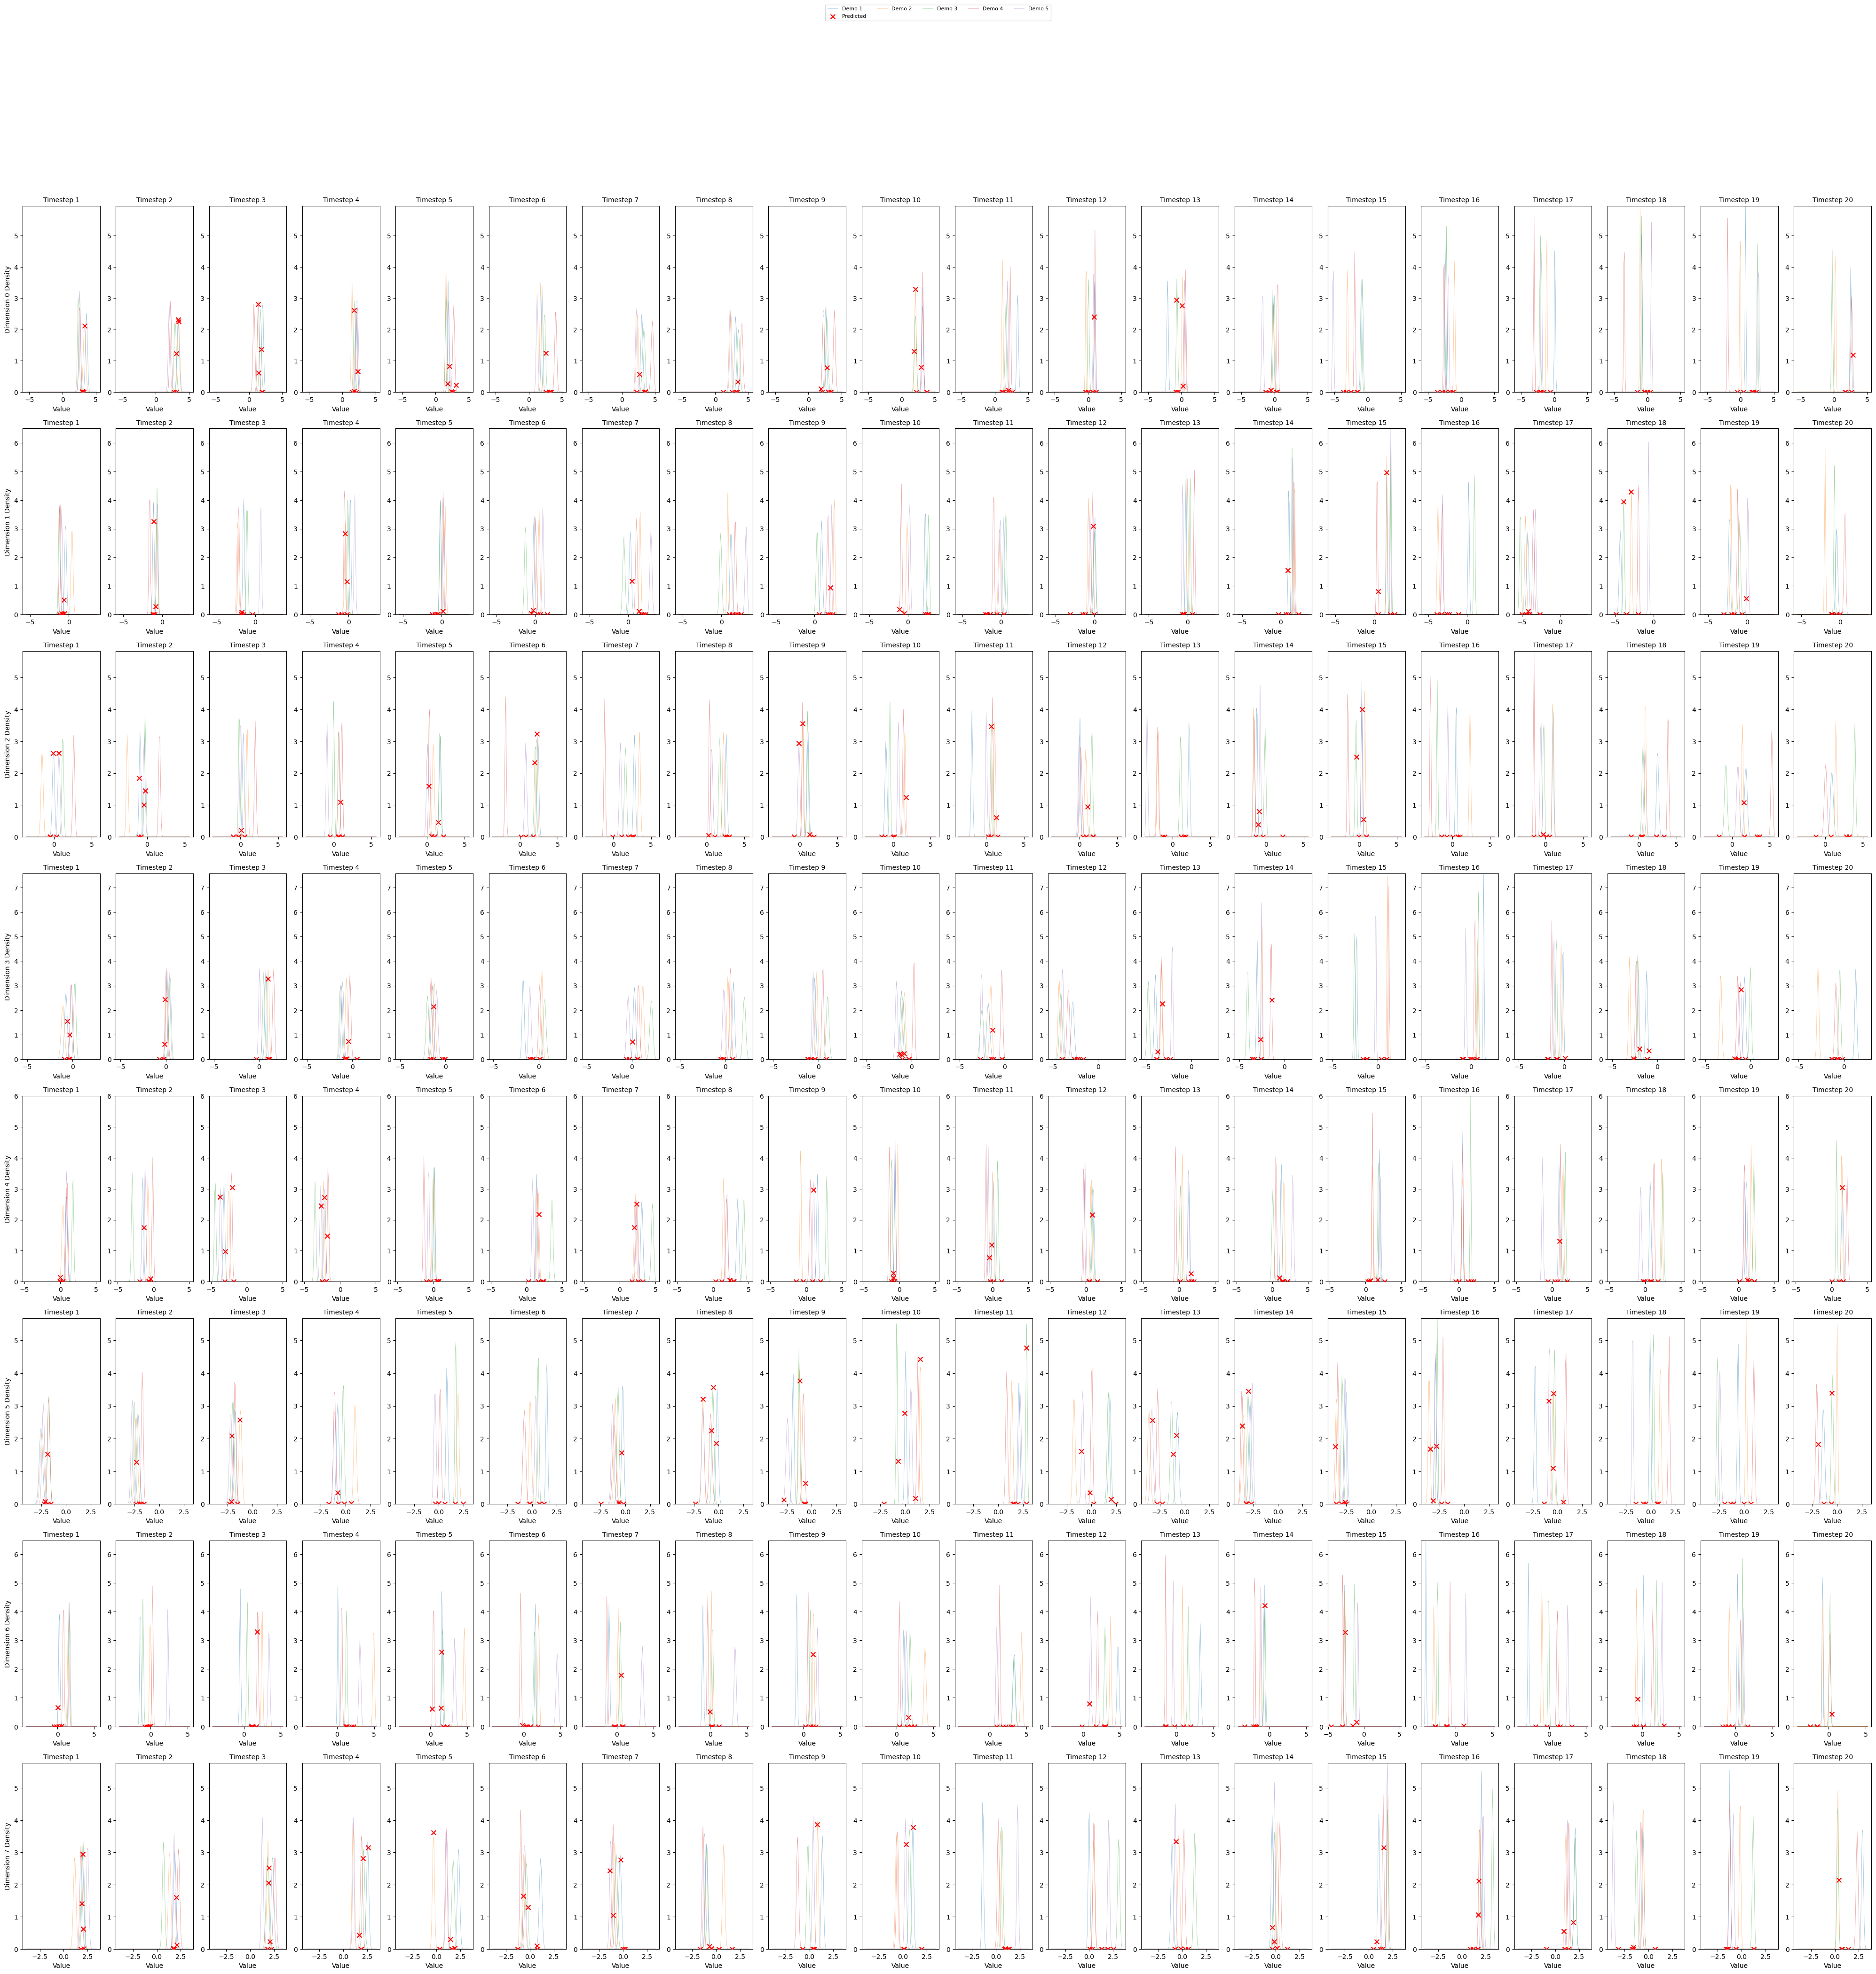

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
plt.close()
# User-defined dimensions to plot
dimensions_to_plot = list(range(8))  # List of dimensions to plot (e.g., [0, 1, 2])

# Unstacking the mus, lvs, and pms tensors based on lengths
mus_list = torch.split(mus, lengths)
lvs_list = torch.split(lvs, lengths)
pms_list = torch.split(pms, lengths)  # Predicted means for each demo

# Maximum number of timesteps across all demos
max_length = max(lengths)

# Determine the global x-axis range for each dimension
x_ranges = {}
for dimension in dimensions_to_plot:
    all_means = torch.cat([mu_demo[:, dimension] for mu_demo in mus_list])
    all_stds = torch.exp(0.5 * torch.cat([lv_demo[:, dimension] for lv_demo in lvs_list]))
    global_min = (all_means - 3 * all_stds).min().item()
    global_max = (all_means + 3 * all_stds).max().item()
    x_ranges[dimension] = np.linspace(global_min, global_max, 100)

# Initialize the plot
fig, axes = plt.subplots(
    nrows=len(dimensions_to_plot), ncols=max_length,
    figsize=(max_length * 2, len(dimensions_to_plot) * 5),
    sharey=False
)

# Adjust axes array for single-row or single-column cases
if len(dimensions_to_plot) == 1:
    axes = [axes]  # Wrap in a list for compatibility
if max_length == 1:
    axes = [[ax] for ax in axes]  # Wrap each row in a list for compatibility

# Loop over dimensions and time steps
for dim_idx, dimension in enumerate(dimensions_to_plot):
    max_y = 0  # Track the maximum y-value for the current dimension
    for timestep in range(max_length):
        ax = axes[dim_idx][timestep]
        ax.set_title(f"Timestep {timestep + 1}", fontsize=10)

        # Overlay the Gaussian distributions and predictions from all demos
        for demo_idx, (mu_demo, lv_demo, pm_demo) in enumerate(zip(mus_list, lvs_list, pms_list)):
            # Check if the current demo has data for this timestep
            if timestep >= mu_demo.size(0):
                continue

            # Extract Gaussian parameters for the selected dimension
            mean = mu_demo[timestep, dimension].item()
            std = torch.exp(0.5 * lv_demo[timestep, dimension]).item()  # logvar -> std
            prediction = pm_demo[timestep, dimension].item()  # Predicted value

            # Plot the Gaussian for this demo at this timestep
            x = x_ranges[dimension]
            y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
            max_y = max(max_y, y.max())  # Update the max y-value for this dimension
            ax.plot(x, y, alpha=0.5, linewidth=0.5, label=f"Demo {demo_idx + 1}" if timestep == 0 and dim_idx == 0 else None)

            # Plot the predicted value on the Gaussian
            pred_y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((prediction - mean) / std) ** 2)
            ax.scatter([prediction], [pred_y], color='red', s=50, marker='x', zorder=5, label="Predicted" if demo_idx == 0 and timestep == 0 and dim_idx == 0 else None)

        ax.set_xlabel("Value")
        if timestep == 0:
            ax.set_ylabel(f"Dimension {dimension} Density")

    # Set the y-axis limit to the maximum y-value for this dimension
    for timestep in range(max_length):
        axes[dim_idx][timestep].set_ylim(0, max_y)

# Move the legend outside the plot
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fontsize=8)

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
plt.show()
